<a href="https://colab.research.google.com/github/sanae-a11y/AI/blob/main/3d_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librairies

In [1]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 659 kB 4.1 MB/s 


In [2]:
import os
import glob
import trimesh
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1234)

#Importation des données

In [3]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473415680/473402300 [==============================] - 6s 0us/step


#Visualisation

In [4]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0085.off"))
mesh.show()

(2048, 3)


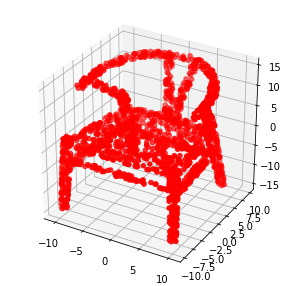

In [5]:
points = mesh.sample(2048)
print(points.shape)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],color='red')
#ax.set_axis_off()
plt.show()

In [6]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [7]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: night_stand
processing class: monitor
processing class: sofa
processing class: dresser
processing class: bathtub
processing class: bed
processing class: desk
processing class: toilet
processing class: chair
processing class: table


**Réduction de dimensionnalité (3D->2D) en utilisant PCA**

In [8]:
from sklearn.preprocessing import StandardScaler
import os
from sklearn.decomposition import PCA 
#Transformer les objets 3D en 2D
Stest = np.zeros((test_points.shape[0], test_points.shape[1],2))
for i in range(test_points.shape[0]):
    scaler = StandardScaler()
    #Effectuer la noramalisation des données
    scaler.fit(test_points[i,:,:])
    scaled_data =scaler.transform(test_points[i,:,:])
    pca = PCA(n_components=2)
    pca.fit(scaled_data)
    Stest[i,:,:] = pca.transform(scaled_data)  

In [9]:
#Transformer les objets 3D en 2D
Strain = np.zeros((train_points.shape[0], train_points.shape[1], 2))
for i in range(train_points.shape[0]):
    scaler = StandardScaler()
    #Effectuer la noramalisation des données
    scaler.fit(train_points[i,:,:])
    scaled_data =scaler.transform(train_points[i,:,:])
    pca = PCA(n_components=2)
    pca.fit(scaled_data)
    Strain[i,:,:] = pca.transform(scaled_data)  

In [10]:
def plot3D_2D(k):
    plt.figure(figsize=(7,5))
    plt.scatter(Strain[k,:,:][:,0],Strain[k,:,:][:,1],color='red')
    plt.xlabel('First Principle Component')
    plt.ylabel('Second Principle Component')
    points = train_points[k,:,:]
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2],color='red')
    #ax.set_axis_off()
    plt.show()
    figure = go.Figure(
    data=[
        go.Scatter3d(
            x=train_points[k,:,:][:,0], y=train_points[k,:,:][:,1], z=train_points[k,:,:][:,2], 
            mode='markers',
            marker=dict(size=1, color='red')
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
    )
    figure.show() 

** Evaluation (PointNet)**

In [11]:
BATCH_SIZE = 32
def augment(points, label):
    # jitter points
    #points == objet (Nx3) associer a une classe 50xNx3
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((Strain, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((Stest, test_labels))


train_dataset = train_dataset.shuffle(len(Strain)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(Stest)).batch(BATCH_SIZE)

#Fonction Utiles 

In [12]:
def conv_bn(x, filters):
    # x: c'est l'input de taille Nx3 
    # filter de taille 1xfilters  --> output Nxfilters
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    #Batch Normalization applique une transformation qui maintient la sortie moyenne proche de 0 et l'écart type de sortie proche de 1
    #batch normalization affects the output of the previous activation layer by subtracting the batch mean, and then dividing by the batch’s standard deviation.
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x) #x > 0


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [13]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

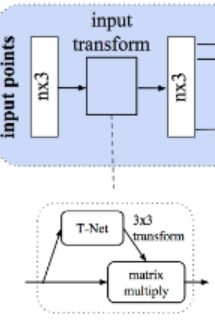

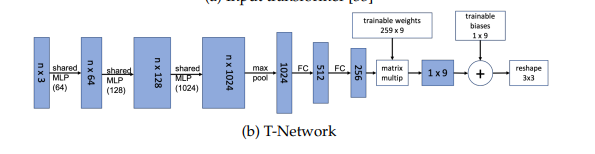

#Model

In [14]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten()) #Id3
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    #matrice 3 x 3
    feat_T = layers.Reshape((num_features, num_features))(x)
    #matrice d'input nx3 multiplier par une matrice 3x3 --> output matrice de taille nx3
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

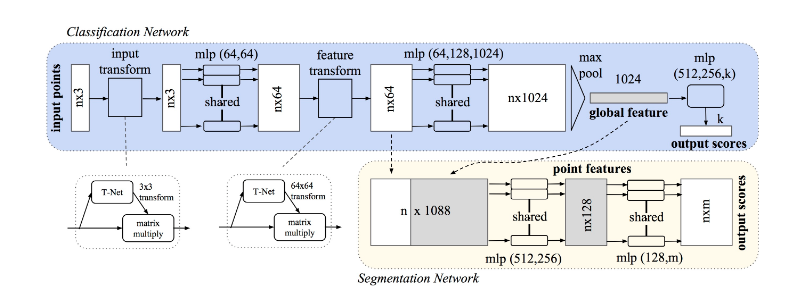

In [15]:
inputs = keras.Input(shape=(NUM_POINTS, 2))

x = tnet(inputs, 2)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 2)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     96          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

#Entrainement de model

In [16]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

history=model.fit(train_dataset, epochs=40, validation_data=test_dataset)

Epoch 1/40
125/125 [==============================] - 475s 4s/step - loss: 2.9940 - sparse_categorical_accuracy: 0.4377 - val_loss: 2.6731 - val_sparse_categorical_accuracy: 0.4868
Epoch 2/40
125/125 [==============================] - 470s 4s/step - loss: 2.4709 - sparse_categorical_accuracy: 0.5703 - val_loss: 2.7344 - val_sparse_categorical_accuracy: 0.5297
Epoch 3/40
125/125 [==============================] - 465s 4s/step - loss: 2.3727 - sparse_categorical_accuracy: 0.5818 - val_loss: 2.7761 - val_sparse_categorical_accuracy: 0.5110
Epoch 4/40
125/125 [==============================] - 469s 4s/step - loss: 2.3224 - sparse_categorical_accuracy: 0.6036 - val_loss: 3.4676 - val_sparse_categorical_accuracy: 0.4846
Epoch 5/40
125/125 [==============================] - 478s 4s/step - loss: 2.2866 - sparse_categorical_accuracy: 0.6039 - val_loss: 2.6585 - val_sparse_categorical_accuracy: 0.5407
Epoch 6/40
125/125 [==============================] - 481s 4s/step - loss: 2.2205 - sparse_cate

#Tester le model

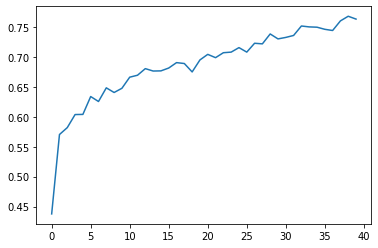

In [17]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(history.history["sparse_categorical_accuracy"])
pyplot.show()

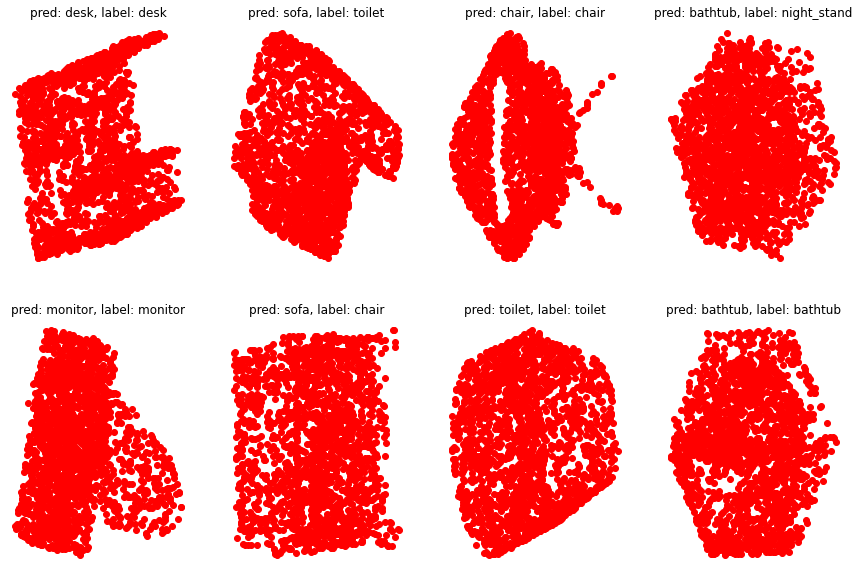

In [18]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points1 = points[:8, ...]
labels1 = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

preds1 = model.predict(points1)
preds1 = tf.math.argmax(preds1, -1)

points1 = points1.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1)
    ax.scatter(points1[i, :, 0], points1[i, :, 1], color="red")
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds1[i].numpy()], CLASS_MAP[labels1.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [19]:
from sklearn.metrics import classification_report
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      0.67      0.57         3
           2       0.60      1.00      0.75         6
           3       0.00      0.00      0.00         0
           4       0.50      1.00      0.67         1
           5       1.00      0.33      0.50         6
           6       1.00      0.67      0.80         3
           7       1.00      0.50      0.67         2
           8       0.80      0.80      0.80         5
           9       0.75      0.75      0.75         4

    accuracy                           0.69        32
   macro avg       0.71      0.62      0.62        32
weighted avg       0.80      0.69      0.69        32



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CONFUSION MATRIX 


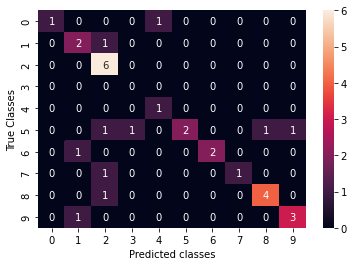

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print("CONFUSION MATRIX ")
sns.heatmap(confusion_matrix(labels, preds),annot=True)
plt.ylabel('True Classes')
plt.xlabel('Predicted classes')
plt.show()